# Tensorflow Similarity Hello World
**Alpha version** here will be dragons


## Notebook goal
Demonstrate the core concept of few-shot learning and how to perform it using TensorFlow Similarity. To do we are going to:
 1. `train()` a similarity model on a sub-set of the 10 fashion MNIST classes that learn how to project images in a cosine space.

 2. `index()` a few examples of each of the class present in the train dataset (e.g 10 per classes).

 3. `lookup()` some the test data to showcase how our models is able to match unseen classes while having only a few examples of each in its index/

 4. `calibrate()` our model to estimate what is the best distance theshold to separate matching elments from elements belonging to different classes.

 5. `evalute()` how well our model/index perform.

 6. `match()` a few examples to test our calibration.

## Performance tips
- The more class you train on the easier it is for the model
- More training epoch  can help improve accuracy
- larger embedding can help improve accuracy
- Augmentation can help improve accuracy
- More examples for calibration gives better results

## Known major limitations
- `batch_lookup()` is broken
- `calibrate()` scores are not correctly computed

There are many other unfinished features and bugs - you have been warmed! 


Send feeback to elieb@  - code: [private github (ask for access)](https://github.com/tensorflow/similarity)

In [1]:
 %load_ext autoreload
 %autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  TensorBoard
from time import  time
from tabulate import tabulate
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

In [3]:
import tensorflow_similarity as tfsim
from tensorflow_similarity.utils import tf_cap_memory
from tensorflow_similarity.losses import TripletLoss
from tensorflow_similarity.layers import MetricEmbedding
from tensorflow_similarity.model import SimilarityModel
from tensorflow_similarity.distance_metrics import avg_neg, avg_pos, dist_gap, max_pos, min_neg
from tensorflow_similarity.samplers import MultiShotMemorySampler
from tensorflow_similarity.samplers import select_examples
from tensorflow_similarity.visualization import viz_neigbors_imgs
from tensorflow_similarity.visualization import confusion_matrix

In [4]:
# make sure TF don't blew up
tf_cap_memory()
print('TensorFlow:', tf.__version__)
print('TensorFlow Similarity', tfsim.__version__)

TensorFlow: 2.4.0
TensorFlow Similarity 0.7.1


**Important**: Tensorflow similarity expect `y_train` to be the examples class as integers. Accordingly contrary to a standard classification that do categorical encoding we are leavig `y_train` as is.

In [5]:
NUM_CLASSES = 6  #@param {type: "slider", min: 1, max: 10}
classes = list(range(10))
# note we added a 11 classes for unknown
labels = ["T-shirt",  "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot", "Unknown"]
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = tf.constant(x_train / 255.0, dtype='float32')
x_test = tf.constant(x_test / 255.0, dtype='float32')

x_restricted, y_restricted = select_examples(x_train, y_train, classes[:NUM_CLASSES], 30000)
print(x_restricted.shape, y_restricted.shape)

(36000, 28, 28) (36000,)


To learn efficiently each batch must contains at least 2 sample of each class. Additionally it is often useful to have multiple examples of each class so we can mine informative triplet using different mining strategies (e.g *semi-hard* mining).

To make this easy tf_similarity offers `Samplers()` that allows to control the number of classes and minimal ammount of examples in each class. Here we are going `MultiShotMemorySampler()` which allows to sample a dataset that reside in memory and have muliples examples per class.

In [6]:
BATCH_SIZE = 32 #@param {type:"integer"}
CLASS_PER_BATCH = 4 #@param {type:"integer"}
BATCH_PER_EPOCH = 3000 #@param {type:"integer"}
sampler = MultiShotMemorySampler(x_restricted, y_restricted, class_per_batch=CLASS_PER_BATCH, batch_size=BATCH_SIZE, batch_per_epoch=BATCH_PER_EPOCH)

# model creation

In [7]:
def get_model():
    tf.keras.backend.clear_session()
    inputs = tf.keras.layers.Input(shape=(28,28))
    x = layers.Reshape((28, 28, 1))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(16, 3, activation='relu')(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    # dont make the embedding to large - its slow down the lookups
    outputs = MetricEmbedding(32)(x)
    return SimilarityModel(inputs, outputs)
model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)  

# Loss definition

Overall Similarity losses (aka metric losses) are similar to other losses except they expect different inputs.

For triplet loss, one of the most popular one, you need to decide what type of triplet mining you want. Usually `hard` mining for positive example and `semi-hard` mining work well and are the default. They are passed explicitly here for reference.

The `distance` parameters specify which distance metric to use to compute the distance between embeddings. `cosine` is usually a great starting point and the default.


In [8]:
distance = 'cosine' #@param ["cosine"]{allow-input: false}
positive_mining_strategy = 'hard' #@param ["easy", "hard"]{allow-input: false}
negative_mining_strategy = 'semi-hard'  #@param ["easy", "semi-hard", "hard"]{allow-input: false}
triplet_loss = TripletLoss(distance=distance,
    positive_mining_strategy=positive_mining_strategy,
    negative_mining_strategy=negative_mining_strategy)

# Compilation

Tensorflow similarity use an extended `compile()` method that allows you to specify distance_metrics (metrics that are computed over the distance between the embedding). 

By default the `compile()` method try to infers what type of distance you are using by looking at the fist loss specified. If you use multiples losses and the distance loss is not the first, then you need to specify the distance function used as `distance=` parameter in the compile function.

In [9]:
LR = 0.0001  #@param {type:"float"}
model = get_model()
metrics = [dist_gap(distance), min_neg(distance), max_pos(distance)]
model.compile(optimizer=Adam(LR), metrics=metrics, loss=triplet_loss)

# Training

Similarity are trained like normal model. Don't expect the validation loss to decrease too much because we only use half of the class on the train data but all class in the validation.

In [10]:
EPOCHS = 10 #@param {type:"integer"}
history = model.fit(sampler, validation_data=(x_test, y_test), batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/10
3000/3000 [==============================] - 57s 16ms/step - loss: 0.5396 - dist_gap: 0.3750 - min_neg: 1.3490 - max_pos: 1.0081 - val_loss: 0.7684 - val_dist_gap: 0.0906 - val_min_neg: 1.2913 - val_max_pos: 1.3819
Epoch 2/10
3000/3000 [==============================] - 46s 15ms/step - loss: 0.3476 - dist_gap: 0.4686 - min_neg: 1.3168 - max_pos: 0.8628 - val_loss: 0.7505 - val_dist_gap: 0.0856 - val_min_neg: 1.2675 - val_max_pos: 1.1819
Epoch 3/10
3000/3000 [==============================] - 46s 15ms/step - loss: 0.2420 - dist_gap: 0.6094 - min_neg: 1.3021 - max_pos: 0.7028 - val_loss: 0.7353 - val_dist_gap: 0.0415 - val_min_neg: 1.2726 - val_max_pos: 1.3140
Epoch 4/10
3000/3000 [==============================] - 46s 15ms/step - loss: 0.1573 - dist_gap: 0.7476 - min_neg: 1.2919 - max_pos: 0.5518 - val_loss: 0.7424 - val_dist_gap: 0.1754 - val_min_neg: 1.2359 - val_max_pos: 1.4113
Epoch 5/10
3000/3000 [==============================] - 47s 16ms/step - loss: 0.1011 - dist_gap:

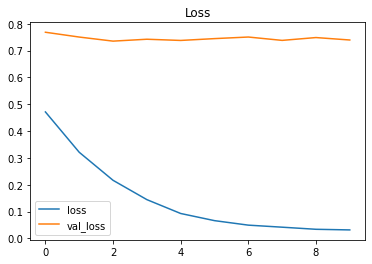

In [11]:
# expect loss: 0.22 / val_loss: 0.74
# oss: 0.1649 vall 0.80
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.show()

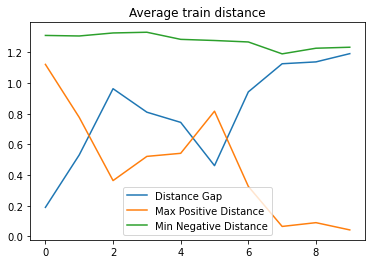

In [12]:
# expect loss: 0.22 / val_loss: 0.74
plt.plot(history.history['dist_gap'])
plt.plot(history.history['max_pos'])
plt.plot(history.history['min_neg'])
plt.legend(['Distance Gap', 'Max Positive Distance', 'Min Negative Distance'])
plt.title('Average train distance')
plt.show()

# Indexing

Indexing is where things get different from traditional classification models. Because the model learned to output an embedding that represent the example position in a metric space and not a classification, we need a way to find which known example(s) are the closest to determine the class of the incoming data (aka nearest neighboors classication).

To do so we need to **create an index of known example from the 10 cloth classes**. We do this by taking **200 examples from the train dataset which amount to 20 examples** for each class and use the `index()` funtion of the model to build the index.

Adding more examples per class, helps increase the accuracy/generalization as you improve the set of known variations that the classifier "knows". 

Reseting the index is not necessary but it ensure we start with a clean index in case of a re-run

In [13]:
x_index, y_index = select_examples(x_train, y_train, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 20)
model.reset_index()
model.index(x_index, y_index)

[Indexing 200 points]
|-Computing embeddings
|-Storing data points in index table
|-Adding embeddings to fast NN matcher index.
|-Optimizing NN matcher index.


# Querying

To "classify" our testing data, we need for each testing example to look for its *k* [nearest neighbors](https://scikit-learn.org/stable/modules/neighbors.html) in the index.

We query a single random example for each class from the test dataset using  `select_examples()` and then find their nearest neighboors using the `single_lookup()` function.

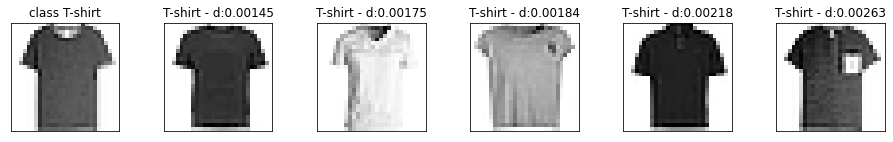

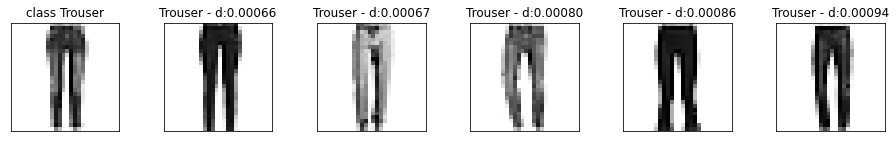

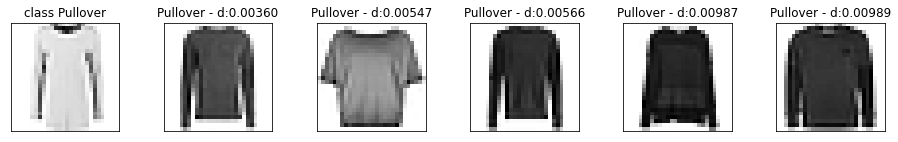

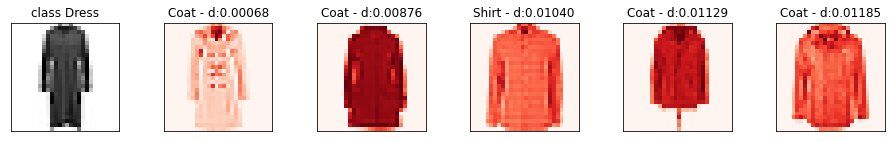

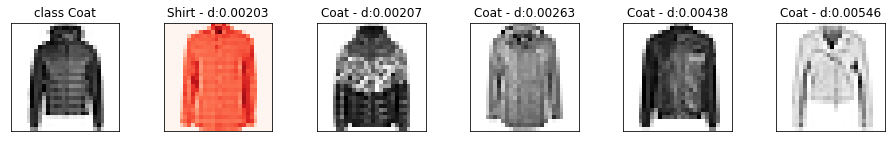

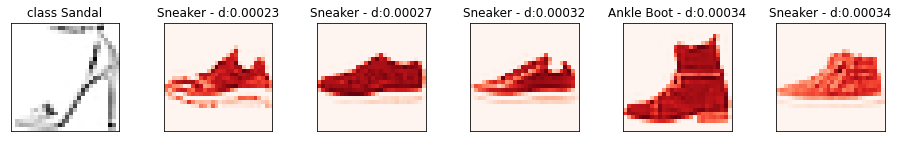

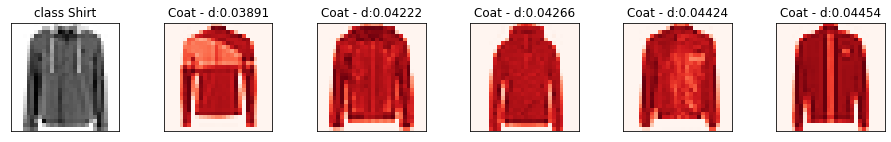

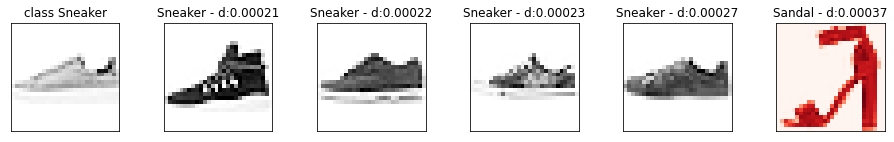

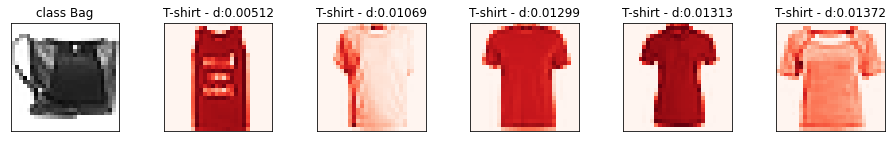

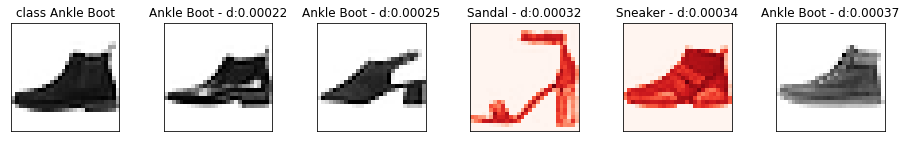

In [14]:
# re-run to test other examples
num_neighboors = 5
x_display, y_display = select_examples(x_test, y_test, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 1)

for idx in np.argsort(y_display):
    # query closest matches
    neighboors = model.single_lookup(x_display[idx], k=num_neighboors)

    # view results close by
    viz_neigbors_imgs(x_display[idx], y_display[idx], neighboors, labels=labels, fig_size=(16, 2), cmap='Greys')



# matching

To be able to tell if an example match a given class, we first need to `calibrate()` the model to know what is the optimal cut point. We compute several cutpoints that correspond to different performance profile:
- **match** is the optimal cutpoint that represent the best balance between precision and recall
- **very likely** is the distance cutpoint that aim to ensure a 0.99 precision.

In [15]:
num_calibration_samples = 5000
calibration = model.calibrate(x_train[:num_calibration_samples], y_train[:num_calibration_samples], verbose=1)


cutpoints       distance
-----------  -----------
very_likely  0
likely       1.20401e-05
optimal      0.20288


Let's look how the performance metrics evolve as the distance between the sample increase. We clearly see the F1 optimial cutpoint where the precision and recall intersect.

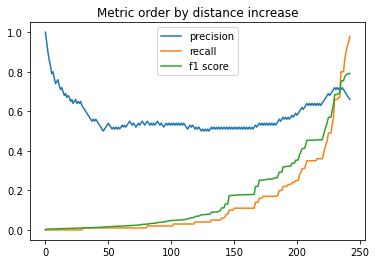

In [16]:
plt.plot(calibration['thresholds']['precision'], label='precision')
plt.plot(calibration['thresholds']['recall'], label='recall')
plt.plot(calibration['thresholds']['f1_score'], label='f1 score')
plt.legend()
plt.title("Metric order by distance increase")
plt.show()

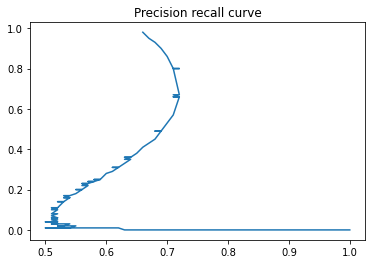

In [17]:
plt.plot(calibration['thresholds']['precision'], calibration['thresholds']['recall'])
plt.title("Precision recall curve")
plt.show()

# Evaluation
We evaluate our model ability to accurately match new examples using our calibrated threshold by testing how many examples from the test sets are correctly matched. The example which have a distance above the cutoff are excluded and labeled as unknown.

The evaluation below reports 

In [18]:
metrics = model.evaluate_index(x_test, y_test)


metric       likely    optimal    very_likely
---------  --------  ---------  -------------
precision  0.777778   0.618488            nan
f1_score   0.777778   0.618488            nan
recall     0.777778   0.618488            nan


# match

Let's now match a 100 examples to see how you can use the `match()` function in practice. `match()` return you what class the example belong to based of the content of the index and allows to use your model to make prediction on an unbounded, added after training, classes!

Note: `match()` return -1 by default when the distance between the submited example and any point of the index is above the distance cutpoint.

**note** This API is WIP -- its unclear what should be returned 

In [19]:
num_matches = 10

matches = model.match(x_test[:num_matches], cutpoint='optimal')
rows = []
for idx, match in enumerate(matches):
    rows.append([match, y_test[idx], match == y_test[idx]])
print(tabulate(rows, headers=['Predicted', 'True', 'correct']))

  Predicted    True    correct
-----------  ------  ---------
          9       9          1
          2       2          1
          1       1          1
          1       1          1
          0       6          0
          1       1          1
          6       4          0
          6       6          1
          5       5          1
          5       7          0


## confusion matrix
Let's select a few hundreds samples for each class in the test set to plot the confusion matrix for a few

**note** `tf.math.confusion_matrix` doesn't support negative class so we are going to use **10 as our unknown class**

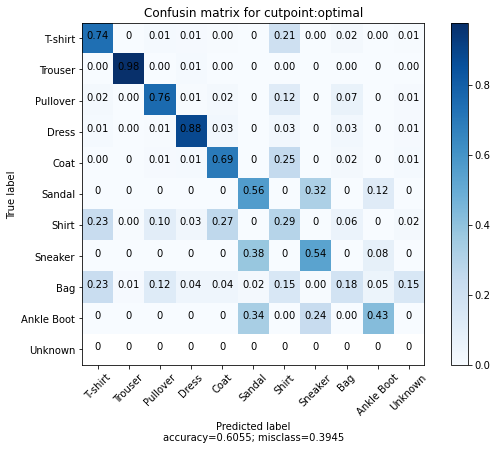

In [20]:
num_example_per_class = 1000
cutpoint = 'optimal'  #@param ["optimal", "very_likely", "likely", "optimistic"]

x_confusion, y_confusion = select_examples(x_test, y_test, range(10), num_example_per_class)

matches = model.match(x_confusion, cutpoint=cutpoint, no_match_label=10)
confusion_matrix(matches, y_confusion, labels=labels, title='Confusin matrix for cutpoint:%s' % cutpoint)

# Index information

Following `model.summary()` you can get information about the index configuration and its performance using `index_summary()`.

In [21]:
model.index_summary()

[Info]
------------------  -----------
distance            cosine
index table         memory
matching algorithm  nmslib_hnsw
evaluator           memory
index size          200
------------------  -----------



[Performance]
-----------  ---------------
num lookups  25020
min              0
max              0.000503778
avg              7.99775e-06
median           0
stddev           6.21799e-05
-----------  ---------------


# Saving and reloading
Saving and reloading the model works as you would expected: 
- `model.save(path)`: save the model and the index on disk (`save_index=False`). By default the index is compressed - can be disabled by setting `compressed=False`
- `model = tf.keras.model.load_model(path)` reload the model. To reload the index you then need to call model.load_index(path)
- `model.save_index(path)` and `model.load_index(path)` allows to save/reload an index indenpendly of saving/loading a model if need to be


## Saving

In [22]:
# save the model and the index
save_path = 'models/hello_world' #@param {type:"string"}
model.save(save_path)

INFO:tensorflow:Assets written to: models/hello_world\assets
INFO:tensorflow:Assets written to: models/hello_world\assets


## Reloading

In [23]:
# reload the model
reloaded_model = load_model(save_path)
# reload the index
reloaded_model.load_index(save_path)

Loading evaluator calibration data
Loading index data
loaded 200 records from models\hello_world\index
Loading index matcher


In [24]:
#check the index is back
reloaded_model.index_summary()

[Info]
------------------  -----------
distance            cosine
index table         memory
matching algorithm  nmslib_hnsw
evaluator           memory
index size          200
------------------  -----------



[Performance]
-----------  -
num lookups  0
min          0
max          0
avg          0
median       0
stddev       0
-----------  -


## Query reloaded model
Querying the reloaded model with its reload index works as expected

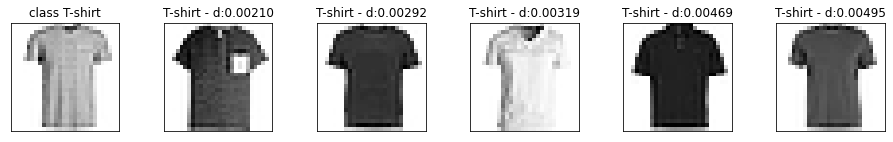

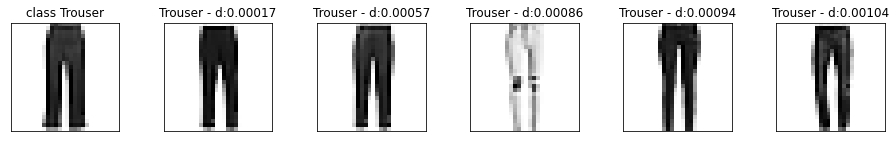

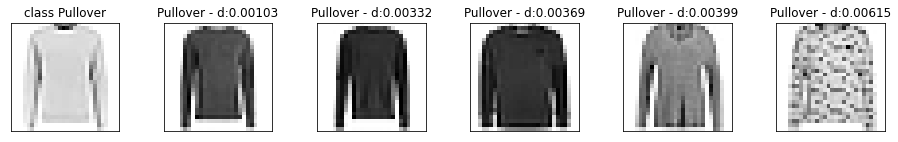

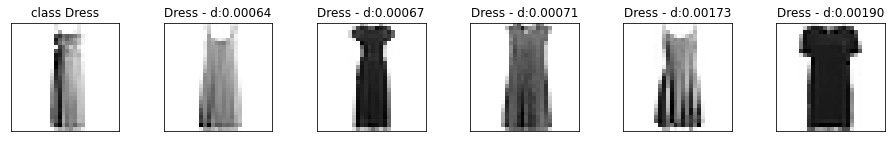

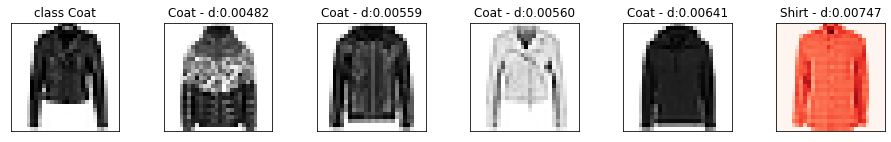

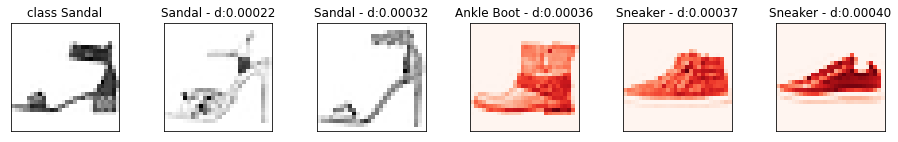

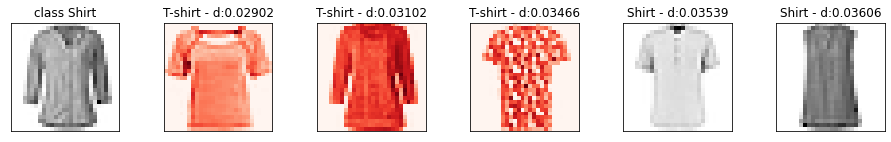

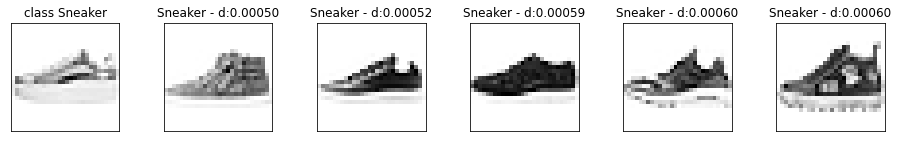

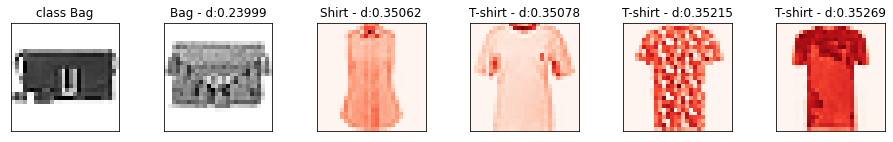

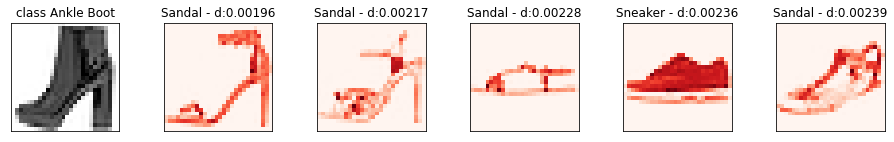

In [25]:
# re-run a query on the loaded model
num_neighboors = 5
x_display, y_display = select_examples(x_test, y_test, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 1)

for idx in np.argsort(y_display):
    # query closest matches
    neighboors = reloaded_model.single_lookup(x_display[idx], k=num_neighboors)

    # view results close by
    viz_neigbors_imgs(x_display[idx], y_display[idx], neighboors, labels=labels, fig_size=(16, 2), cmap='Greys')